## Gempy to pyGIMLi - 3D  onwards to inversion
### Adapted example from transform2021 Hackathon 

The purpose of this notebook is to show the bridge between Gempy - pyGIMLi using subsurface objects. These new functions are in the pyGIMLi library under meshtools and help support the [subsuface library](https://softwareunderground.github.io/subsurface/index.html). This example has helped extend pyGIMLi 3D functionality. Right now `mt.fromSubsurface` supports unstructured and structured grids. This examples goes through different gempy models converted to pyGIMLi meshes. 

Code run on RWTH cluster, 32GB ram, 2 cores 

Original package import

In [1]:
import shutil
import pandas as pd
import numpy as np
import subsurface as ss
import pooch
import gempy as gp
import xarray 
import matplotlib.pyplot as plt
import subsurface.reader.read_netcdf
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer.pv import drawStreamLines, drawSlice

In [2]:
#service desk suggestion so that the figures run on cluster 
import pyvista
pyvista.start_xvfb() 


In [3]:
#running 1.4.1?
pg.__version__

'1.4.1'

In [4]:
#running 2.2.12?
gp.__version__

'2.2.12'

Import additional packages for inversion, some of the functions are not released (as of 07/2023)


In [5]:
#mesh tools already imported as mt
from pygimli.physics.gravimetry import MagneticsModelling
from pygimli.physics.gravimetry import (#gradGZCylinderHoriz,
                                        #gradGZHalfPlateHoriz,
                                        #gradUCylinderHoriz,
                                        #gradUHalfPlateHoriz,
                                        solveGravimetry)

from pygimli.physics.gravimetry import GravityModelling2D
from pygimli.viewer import pv

from pygimli.utils.utils import ProgressBar

Functions for inversion 

In [6]:
#importing classes 
def SolveGravMagHolstein(mesh, pnts, cmp, igrf=None, foot=np.inf):
    """Solve gravity and/or magnetics problem after Holstein (1997).

    Parameters
    ----------
    mesh : pygimli:mesh
        tetrahedral or hexahedral mesh
    pnts : list|array of (x, y, z)
        measuring points
    cmp : list of str
        component list of: gx, gy, gz, TFA, Bx, By, Bz, Bxy, Bxz, Byy, Byz, Bzz
    igrf : list|array of size 3 or 7
        international geomagnetic reference field, either
        [D, I, H, X, Y, Z, F] - declination, inclination, horizontal field,
                               X/Y/Z components, total field OR
        [X, Y, Z] - X/Y/Z components

    Returns
    -------
    out : ndarray (nPoints x nComponents x nCells)
        kernel matrix to be multiplied with density or susceptibility
    """
    if pnts is None:
        pnts = [[0.0, 0.0]]

    doG = np.any([c[0] == "g" for c in cmp])
    doB = np.any([c[0] == "B" and len(c) == 2 for c in cmp]) or "TFA" in cmp
    doBT = np.any([c[0] == "B" and len(c) == 3 for c in cmp])
    B_tens = None

    kernel = np.zeros((mesh.cellCount(), len(pnts), len(cmp)))
    if igrf:
        if len(igrf) == 3:  # an X, Y, Z vector
            F = np.linalg.norm(igrf)
            fakt = F / (4*np.pi)
            B_dir = np.array(igrf) / F
        elif len(igrf) == 7:  # an IGRF vector (D, I, H, X, Y, Z, F)
            fakt = igrf[6] / (4*np.pi)
            myigrf = np.array(igrf[3:6])
            B_dir = myigrf / np.linalg.norm(myigrf)
        else:
            raise Exception("Could not use IGRF vector. Len must be 3 or 7!")
    elif doB or doB:
        raise Exception("Specify IGRF!")

    b_list, c_list = [], []
    for bd in mesh.boundaries():
        b_list.append([n.id() for n in bd.allNodes()])
        c_list.append([bd.leftCell(), bd.rightCell()])

    b_list = np.array(b_list)
    lb = b_list.shape

    n_list = np.array([n.pos() for n in mesh.nodes()])

    cl, cr = [], []
    for i, c in enumerate(c_list):
        if c[0]:
            cl.append([i, c[0].id()])
        if c[1]:
            cr.append([i, c[1].id()])

    cl = np.array(cl)
    cr = np.array(cr)

    rr = range(0, mesh.cellCount())
    rs = np.roll(range(0, lb[1]), -1)

    temp = np.zeros((len(pnts), lb[0], len(cmp)))
    pBar = ProgressBar(its=len(pnts), width=40, sign='+')
    nb = n_list[b_list]
    for i, p in enumerate(pnts):
        r1 = nb - p
        r2 = r1[:, rs, :]
        r0 = r2 - r1
        u = np.sum(np.cross(r1, r2), 1)
        u = u / np.expand_dims(np.linalg.norm(u, axis=1), axis=1)
        ut = np.tile(u, lb[1]).reshape((lb[0], lb[1], 3))
        ll = np.linalg.norm(r0, axis=2)
        t = r0/np.expand_dims(ll, axis=2)
        lm = (np.sum(r1*t, 2) + np.sum(r2*t, 2)) / 2
        h = np.cross(t, ut)
        hn = np.sum(h*r1, 2)
        v = np.sum(ut*r1, 2)
        r1n = np.linalg.norm(r1, axis=2)
        r2n = np.linalg.norm(r2, axis=2)
        rm = (r1n+r2n)/2
        lumbda = ll/(2*rm)

        jj = 0
        if doG: # gravitational field
            g = hn*np.arctanh(lumbda)-np.sign(v)*v*np.arctan2(
                hn*lumbda, (rm*(1-lumbda**2)+abs(v)))
            g_vec = 2 * u * np.expand_dims(np.sum(g, 1), axis=1)

            if 'g' in cmp:
                temp[i, :, jj] = g
                jj += 0

            if 'gx' in cmp:
                temp[i, :, jj] = g_vec[:, 0]
                jj += 1

            if 'gy' in cmp:
                temp[i, :, jj] = g_vec[:, 1]
                jj += 1

            if 'gz' in cmp:
                temp[i, :, jj] = g_vec[:, 2]
                jj += 1

            # if 'gxx' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 0]
            # if 'gxy' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 1]
            # if 'gxz' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 2]
            # if 'gyy' in cmp:
            #     temp[:, jj]=G_tens[:, 1, 1]
            # if 'gyz' in cmp:
            #     temp[:, jj]=G_tens[:, 1, 2]
            # if 'gzz' in cmp:
            #     temp[:, jj]=G_tens[:, 2, 2]

        if doB or doBT:
            # magnetic field vector and gravity gradient tensor
            b = h*np.expand_dims(np.arctanh(lumbda), axis=2) - \
                ut*np.expand_dims(np.sign(v)*np.arctan2(
                    hn*lumbda, (rm*(1-lumbda**2)+abs(v))), axis=2)
            P = np.dot(u, B_dir)
            B_vec = np.expand_dims(P, 1) * np.sum(b, 1)
            B_vec = 2 * np.expand_dims(P, 1) * np.sum(b, 1)

            if 'TFA' in cmp:
                temp[i, :, jj] = fakt*B_vec.dot(B_dir)
                jj += 1

            if 'Bx' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 0]
                jj += 1

            if 'By' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 1]
                jj += 1

            if 'Bz' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 2]
                jj += 1

            if doBT:  # magnetic gradient tensor
                d = (-2*lumbda*hn) / (r1n*r2n*(1-lumbda**2))
                e = (-2*lumbda*lm) / (r1n*r2n)
                f = (-2*lumbda*v) / (r1n*r2n*(1-lumbda**2))

                h1 = np.expand_dims(h, axis=3)
                h2 = np.swapaxes(h1, 2, 3)
                t1 = np.expand_dims(t, axis=3)
                t2 = np.swapaxes(t1, 2, 3)
                u1 = np.expand_dims(ut, axis=3)
                u2 = np.swapaxes(u1, 2, 3)

                B = (h1*h2-u1*u2)*np.expand_dims(d, (2, 3)) + \
                    (t1*h2+h1*t2)*np.expand_dims(e, (2, 3))/2 + \
                    (h1*u2+u1*h2)*np.expand_dims(f, (2, 3))

                B_tens = np.expand_dims(P, (1, 2)) * np.sum(B, 1)

                if 'Bxx' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 0]
                    jj += 1

                if 'Bxy' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 1]
                    jj += 1

                if 'Bxz' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 2]
                    jj += 1

                if 'Byy' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 1, 1]
                    jj += 1

                if 'Byz' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 1, 2]
                    jj += 1

                if 'Bzz' in cmp:
                    temp[i, :, jj] = fakt * B_tens[:, 2, 2]
                    jj += 1

    pBar.update(i)
    kernel += np.array([np.sum(temp[:, cl[cl[:, 1] == j, 0]], 1) for j in rr])
    kernel -= np.array([np.sum(temp[:, cr[cr[:, 1] == j, 0]], 1) for j in rr])

    return kernel.transpose([1, 2, 0])

In [7]:
class GravityModelling(pg.frameworks.MeshModelling):
    """Magnetics modelling operator using Holstein (2007)."""

    def __init__(self, mesh, points, cmp=["gz"], foot=None):
        """Setup forward operator.

        Parameters
        ----------
        mesh : pygimli:mesh
            tetrahedral or hexahedral mesh
        points : list|array of (x, y, z)
            measuring points
        cmp : list of str
            component of: gx, gy, gz, TFA, Bx, By, Bz, Bxy, Bxz, Byy, Byz, Bzz
        """
        # check if components do not contain g!
        super().__init__(mesh=mesh)
        self.createRefinedForwardMesh(refine=False, pRefine=False)
        self.mesh_ = mesh
        self.sensorPositions = points
        self.components = cmp
        self.footprint = foot
        self.kernel = None
        self.J = pg.matrix.BlockMatrix()
        self.createKernel()

    def createKernel(self):
        """Create computational kernel."""
        self.kernel = SolveGravMagHolstein(self.mesh_,
                                           pnts=self.sensorPositions,
                                           cmp=self.components,
                                           foot=self.footprint)
        self.J = pg.matrix.BlockMatrix()
        self.Ki = []
        self.Ji = []
        for iC in range(self.kernel.shape[1]):
            self.Ki.append(np.squeeze(self.kernel[:, iC, :]))
            self.Ji.append(pg.matrix.NumpyMatrix(self.Ki[-1]))
            self.J.addMatrix(self.Ji[-1], iC*self.kernel.shape[0], 0)

        self.J.recalcMatrixSize()
        self.setJacobian(self.J)


    def setMesh(self, mesh, ignoreRegionManager=False):
        """Set the mesh."""
        super().setMesh(mesh, ignoreRegionManager=False)
        self.createKernel(mesh)


    def response(self, model):
        """Compute forward response."""
        return self.J.dot(model)

    def createJacobian(self, model):
        """Do nothing as this is a linear problem."""

### Gravity Forward Operator Test 

We will use another Gempy model to simulate the gravity response in the pyGIMLi mesh

The following cell may take some time. We are building the model from an example Gempy data set 

Straelen model - best to adjust resolution and size based on the available computational power, original-sized model requires about 25GB RAM but fails in creating FOP for inversion casue too big of a mesh

'MemoryError: Unable to allocate 174. GiB for an array with shape (15376, 1520000, 1) and data type float64'

Reducinng the area to more exact survey location, as well as coarsening the mesh allows for further operations, at cost of final resolution

!! note ... cannot change the model size, once gp.init_model has been run, restarting kernel helps


In [8]:
geo_model = gp.create_model('Fault_model_pygimli')

data_path = '/rwthfs/rz/cluster/home/yq015632'

In [9]:
import os
os.getcwd()

'/rwthfs/rz/cluster/home/yq015632/jupyterlab/trials_with_gimli'

In [10]:
# Importing the data from CSV-files and setting extent and resolution
#ORIGNIAL 

#gp.init_data(geo_model, [202000, 218000., 378000, 392000., 0, 2500.], [100, 100, 50],             
 #            path_o= data_path + '/jupyterlab/trials_with_gimli/orientations_sf_rev65.csv',
  #           path_i= data_path +  '/jupyterlab/trials_with_gimli/model_points_sf_rev3.csv',
   #         default_values=True)


In [11]:
#Slighlty smaller extent

#gp.init_data(geo_model, [210000, 218000., 378000, 392000., 0, 2500.], [100, 100, 50],             
 #            path_o= data_path + '/jupyterlab/trials_with_gimli/orientations_sf_rev65.csv',
  #           path_i= data_path +  '/jupyterlab/trials_with_gimli/model_points_sf_rev3.csv',
   #         default_values=True)


In [76]:
#Slighlty smaller extent

gp.init_data(geo_model, [212000, 220000., 378000, 392000., 0, 2500.], [20, 20, 20],             
             path_o= data_path + '/jupyterlab/trials_with_gimli/orientations_sf_rev65.csv',
             path_i= data_path +  '/jupyterlab/trials_with_gimli/model_points_sf_rev3.csv',
            default_values=True)


Active grids: ['regular']


Fault_model_pygimli  2023-07-28 16:32

In [77]:
# smaller model

#gp.init_data(geo_model, [212000, 218000., 380000, 388000., 0, 2500.], [10, 10, 5],             
 #            path_o= data_path + '/jupyterlab/trials_with_gimli/orientations_sf_rev65.csv',
  #           path_i= data_path +  '/jupyterlab/trials_with_gimli/model_points_sf_rev3.csv',
   #          default_values=True)


In [78]:
gp.map_stack_to_surfaces(geo_model,
                         {"Fault_Series": 'Viersen_Fault',
                          "Fault_Series2": 'Viersen_Div1',
                          "Strat_Series": ('Base_TertiaryE', 'Top_DevonianE','Base_DevonianE', 'BasementE',
                                           'Base_TertiaryW', 'Top_DevonianW','Base_DevonianW', )},
                         remove_unused_series=True)

geo_model.set_is_fault(['Fault_Series'])
geo_model.set_is_fault(['Fault_Series2'])


#Compiling THEANO functions
#geo_model.update_to_interpolator()
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_run',
                    )
 
model = gp.compute_model(geo_model, to_subsurface=True) #Compute Model
#gp.plot_2d(geo_model)

Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                              values
range              16317.1688720807
$C_o$            6339285.7142857136
drift equations        [3, 3, 3, 3]


In [79]:
color_dict = {'Viersen_Fault': '#015482', 'Viersen_Div1': '#015482', 
              'Base_TertiaryE': '#ffbe00', 'Base_TertiaryW': '#ffbe00', 
              'Top_DevonianE': '#728f02', 'Top_DevonianW': '#728f02',
              'Base_DevonianE': '#4878d0', 'Base_DevonianW': '#4878d0',
              'BasementE': '#ff3f20', 'basement': '#ff3f20'
             }
# then change colors of your geo_model by:
geo_model.surfaces.colors.change_colors(colordict=color_dict)

/cvmfs/sys.hpc.itc.rwth-aachen.de/jupyter/clients/geophy/lib/python3.9/site-packages/gempy/plot/plot_api.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


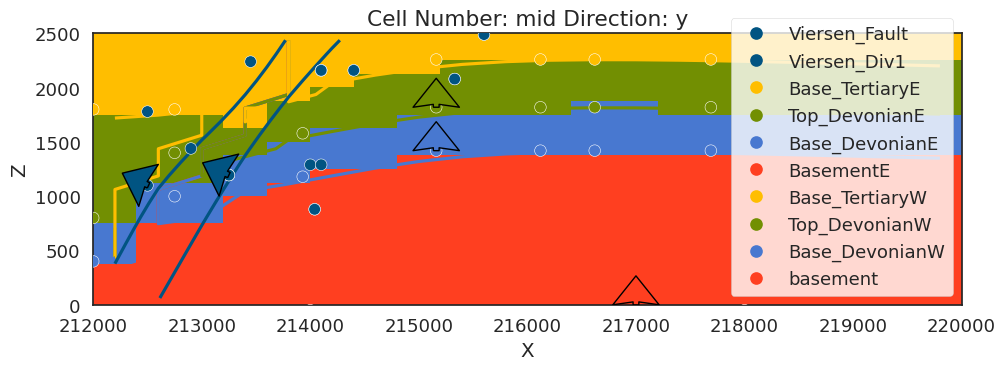

In [80]:
gp.plot_2d(geo_model)

In [81]:
#Assigning densities to the layers 
geo_model.add_surface_values([0, 
                              0, 
                              2.6,  
                              2.65,
                              2.8,
                              3.5,
                              2.6,
                              2.65,
                              2.8,
                              3.5,], ['value_0'])

surface         series  order_surfaces    color  id  value_0
0   Viersen_Fault   Fault_Series               1  #015482   1     0.00
1    Viersen_Div1  Fault_Series2               1  #015482   2     0.00
2  Base_TertiaryE   Strat_Series               1  #ffbe00   3     2.60
3   Top_DevonianE   Strat_Series               2  #728f02   4     2.65
4  Base_DevonianE   Strat_Series               3  #4878d0   5     2.80
5       BasementE   Strat_Series               4  #ff3f20   6     3.50
6  Base_TertiaryW   Strat_Series               5  #ffbe00   7     2.60
7   Top_DevonianW   Strat_Series               6  #728f02   8     2.65
8  Base_DevonianW   Strat_Series               7  #4878d0   9     2.80
9        basement       Basement               1  #ff3f20  10     3.50

Now we convert the Gempy model into pyGIMLi mesh and also export a vtk file that allows us to view and further analyze using a 3D plotting software

In [82]:
gempymesh = model.s_regular_grid
pgmesh_new = mt.fromSubsurface(gempymesh, order='F')

In [83]:
#avoiding uneccessary exports and plotting for optimisation
pgmesh_new.exportVTK('pgmesh_vtk') 

Now that we are in the pyGIMLi world, we assign density values to the layers from Gempy Model 

In [84]:
pvec = pgmesh_new['property_matrix']
pvec = np.around(pvec) #Round Float values from property matrix
dens = np.zeros(pvec.shape[0])
(unique, counts) = np.unique(pvec, return_counts=True)
layers = np.asarray(unique)
print(layers)

## Assign values to new dens vec 
dens[pvec==10] = 3500
dens[pvec==9] = 2800
dens[pvec==8] = 2650
dens[pvec==7] = 2600
dens[pvec==6] = 3500
dens[pvec==5] = 2800
dens[pvec==4] = 2650
dens[pvec==3] = 2600


density = pg.solver.cellValues(pgmesh_new, dens)
#pg.show(pgmesh_new, density, label='density')

[ 3.  4.  5.  6.  7.  8.  9. 10.]


In [85]:
#pgmesh_new.exportVTK('pgmesh_densities.vtk')

In [86]:
ax, _ = pg.show(pgmesh_new, hold=True, alpha=0.3)
drawSlice(ax, pgmesh_new, normal=[0,1,0], data=density, label="Density")
ax.show()

In [87]:
ax, _ = pg.show(pgmesh_new, hold=True, alpha=0.3)
drawSlice(ax, pgmesh_new, normal=[1,1,0], data=density, label="Density")
ax.show()

In [88]:
ax, _ = pg.show(pgmesh_new, hold=True, alpha=0.3)
drawSlice(ax, pgmesh_new, normal=[2,2,0], data=density, label="Density")
ax.show()

We need to extend the 3D grid to avoid edge effects when calculating the gravity potential. We do this by using the handy function : `pg.meshtools.appendBoundaryGrid` . We extend the boundaries to 0 and interpolate our densities value to the larger mesh. 

In [89]:
#following cell takes several (7-10) minutes on 2core 32GB RAM hpc

In [90]:
l = np.geomspace(100, 8000, num=3) #We extend using logarithmic values to have bigger cells at the further boundaries.
ml = pg.meshtools.appendBoundaryGrid(pgmesh_new, xbound=l, ybound=l, zbound=l, 
                                     isSubSurface=False, verbose=True)
                                     
dDensL = pg.interpolate(pgmesh_new, density, ml.cellCenters(), fallback=0)

pg.show(ml, dDensL, label='dDensl', alpha=0.3)

(<pyvista.plotting.plotting.Plotter at 0x1487ac5f04c0>, None)

No we calculate the gravity potential. The gravitational potential of a spatially distributed density anomaly can be obtained using a finite-element solution of the following equation:

$$ \nabla^{2} \phi=-4 \pi G \rho(x, y, z) $$

The gravitational anomaly is then given by:

$$ g(x, y, z)=-\nabla \phi $$ 

The following cell may take some time : 

In [91]:
#ussually about 15-20 minutes on hpc with 2cores and 32 RAM with the big model, several seconds with smallest,

In [92]:
pg.tic()
phi = 4. * np.pi * pg.physics.constants.GmGal * pg.solver.solve(ml, a=1, f=dDensL, bc={'Dirichlet':{'*': 0.0}})
grad = -pg.solver.grad(ml, phi)
pg.toc()
#pg.show(ml, phi, label='phi')

Elapsed time is 16.69 seconds.


In [93]:
pg.show(ml, phi, label='phi')

(<pyvista.plotting.plotting.Plotter at 0x1487ac0c0310>, None)

We place the sensors near the area of interest from the initial Gempy model and look at the G_z 

In [31]:
#next cell also takes some minutes...

In [32]:
height = 350
n = np.linspace(0, 100, 20)
mesh2D = pg.createGrid(n,n)
mesh3D = pg.createGrid(n, n, np.zeros(len(n))+height)    
gz_fem3d = pg.interpolate(ml, grad[:,2], destPos=mesh3D.cellCenters())
pg.show(mesh3D,gz_fem3d, label='gz_fem3d',alpha=0.3)

./core/src/mesh.cpp:1861		void GIMLI::Mesh::create3DGrid(const GIMLI::RVector&, const GIMLI::RVector&, const GIMLI::RVector&, int, bool) Warning! there are non-unique values in pos


(<pyvista.plotting.plotting.Plotter at 0x148963865370>, None)

32.462257021586204

./core/src/mesh.cpp:1861		void GIMLI::Mesh::create3DGrid(const GIMLI::RVector&, const GIMLI::RVector&, const GIMLI::RVector&, int, bool) Warning! there are non-unique values in pos


<Axes:>

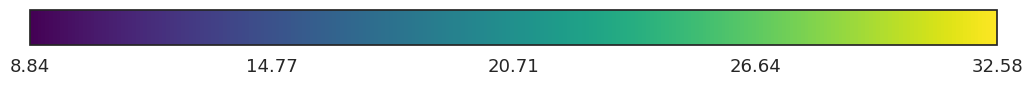

In [94]:
height = 1250
n = np.linspace(212000, 220000, 20)
m = np.linspace(378000, 392000, 20)
mesh2D = pg.createGrid(n,m)
mesh3D = pg.createGrid(n, m, np.zeros(len(n))+height)    
gz_fem3d = pg.interpolate(ml, grad[:,2], destPos=mesh3D.cellCenters())
#pg.show(mesh3D,gz_fem3d, label='gz_fem3d', alpha=0.3)
pg.show(mesh3D,gz_fem3d, label='gz_fem3d')
#pg.viewer.mpl.createColorBar(gz_fem3d)
pg.viewer.mpl.createColorBarOnly(cMin=min(gz_fem3d), cMax=max(gz_fem3d), logScale=False, cMap=None, nLevs=5, label=None, orientation='horizontal', savefig=None, ax=None)


In [33]:
height = 1250
n = np.linspace(210000, 218000, 60)
m = np.linspace(378000, 392000, 20)
mesh2D = pg.createGrid(n,m)
mesh3D = pg.createGrid(n, m, np.zeros(len(n))+height)    
gz_fem3d = pg.interpolate(ml, grad[:,2], destPos=mesh3D.cellCenters())
pg.show(mesh3D,gz_fem3d, label='gz_fem3d', alpha=0.3)


./core/src/mesh.cpp:1861		void GIMLI::Mesh::create3DGrid(const GIMLI::RVector&, const GIMLI::RVector&, const GIMLI::RVector&, int, bool) Warning! there are non-unique values in pos


(<pyvista.plotting.plotting.Plotter at 0x14896385fb50>, None)

In [ ]:
pg.show

In [39]:
height = 2500
n = np.linspace(210000, 218000, 60)
m = np.linspace(378000, 392000, 20)
mesh2D = pg.createGrid(n,m)
mesh3D = pg.createGrid(n, m, np.zeros(len(n))+height)    
gz_fem3d = pg.interpolate(ml, grad[:,2], destPos=mesh3D.cellCenters())
pg.show(mesh3D,gz_fem3d, label='gz_fem3d', alpha=0.3)

./core/src/mesh.cpp:1861		void GIMLI::Mesh::create3DGrid(const GIMLI::RVector&, const GIMLI::RVector&, const GIMLI::RVector&, int, bool) Warning! there are non-unique values in pos


(<pyvista.plotting.plotting.Plotter at 0x1488bf64ad30>, None)

In [35]:
height = 0
n = np.linspace(210000, 218000, 60)
m = np.linspace(378000, 392000, 20)
mesh2D = pg.createGrid(n,m)
mesh3D = pg.createGrid(n, m, np.zeros(len(n))+height)    
gz_fem3d = pg.interpolate(ml, grad[:,2], destPos=mesh3D.cellCenters())
pg.show(mesh3D,gz_fem3d, label='gz_fem3d', alpha=0.3)

./core/src/mesh.cpp:1861		void GIMLI::Mesh::create3DGrid(const GIMLI::RVector&, const GIMLI::RVector&, const GIMLI::RVector&, int, bool) Warning! there are non-unique values in pos


(<pyvista.plotting.plotting.Plotter at 0x14896ff23190>, None)

In [38]:
height = 1000
n = np.linspace(210000, 218000, 60)
m = np.linspace(378000, 392000, 60)
mesh2D = pg.createGrid(n,m)
mesh3D = pg.createGrid(n, m, np.zeros(len(n))+height)    
gz_fem3d = pg.interpolate(ml, grad[:,2], destPos=mesh3D.cellCenters())
#pg.show(mesh3D,gz_fem3d, label='gz_fem3d', alpha=0.3)
pg.show(mesh3D,gz_fem3d, label='gz_fem3d')

./core/src/mesh.cpp:1861		void GIMLI::Mesh::create3DGrid(const GIMLI::RVector&, const GIMLI::RVector&, const GIMLI::RVector&, int, bool) Warning! there are non-unique values in pos


(<pyvista.plotting.plotting.Plotter at 0x1488bf66a760>, None)

In [31]:
#loosely based on 3D magnetics and 2D gravity tutorials
#see dev version of pg 
# http://dev.pygimli.org/_examples_auto/4_gravimetry_magnetics/plot_05_inv-gravity-3d.html#sphx-glr-examples-auto-4-gravimetry-magnetics-plot-05-inv-gravity-3d-py
grid=pgmesh_new

In [32]:
#assigning the densities in preparation for the fop 
grid['synth']=dens

In [33]:
#checking the size
grid

Mesh: Nodes: 9261 Cells: 8000 Boundaries: 25200
Mesh contains data: block_matrix[0,...,3), fault_mask[0,...,3), mask_matrix[0,...,3), property_matrix, scalar_field_matrix[0,...,3), synth

In [34]:
pgmesh_new

Mesh: Nodes: 9261 Cells: 8000 Boundaries: 25200
Mesh contains data: block_matrix[0,...,3), fault_mask[0,...,3), mask_matrix[0,...,3), property_matrix, scalar_field_matrix[0,...,3), synth

In [35]:
#density assigned to each of the cells 
len(dens)

8000

In [36]:
testmesh=model.s_regular_grid

In [37]:
#checking the size
testmesh

StructuredData(data=<xarray.Dataset>
Dimensions:              (Properties: 1, X: 20, Y: 20, Z: 20, Features: 3)
Coordinates:
  * Features             (Features) <U13 'Fault_Series' ... 'Strat_Series'
  * Properties           (Properties) <U2 'id'
  * X                    (X) float64 2.102e+05 2.106e+05 ... 2.174e+05 2.178e+05
  * Y                    (Y) float64 3.784e+05 3.79e+05 ... 3.91e+05 3.916e+05
  * Z                    (Z) float64 62.5 187.5 312.5 ... 2.312e+03 2.438e+03
Data variables:
    property_matrix      (Properties, X, Y, Z) float64 10.0 10.0 ... 3.0 3.0
    block_matrix         (Features, Properties, X, Y, Z) float64 1.0 1.0 ... 3.0
    scalar_field_matrix  (Features, X, Y, Z) float64 -0.3062 -0.302 ... 98.49
    mask_matrix          (Features, X, Y, Z) bool False False ... True True
    fault_mask           (Features, X, Y, Z) bool True True True ... False False, data_array_name='data_array')

In [38]:
#gravity data import - processed data from straelen 
#bouger anomaly corrected - background density 2400 g/cc
dataset = pd.read_csv('gravity_processed.csv')
d_obs_x = dataset['CORRECTEDx']
d_obs_y = dataset['CORRETED']
d_obs_z = dataset['Ele_tiff']
d_obs_grav  = dataset['abs_Grav'] - dataset['gravity_bouger_corrected2400']
d_obs = {'X': d_obs_x, 'Y': d_obs_y, 'Z': d_obs_z, 'abs_grav': dataset['abs_Grav'], 'bouger anomaly': dataset['gravity_bouger_corrected2400']}
df = pd.DataFrame(d_obs)
df

X            Y        Z           abs_grav  bouger anomaly
0    218366.5117  381192.5130  41.4175  981184.4800000000    -2.872240738
1    218569.6151  381290.6376  38.6000  981185.3003000000    -2.713734740
2    218743.2993  381370.5864  37.0550  981186.0181000000    -2.379001843
3    218878.7973  381323.1159  35.9175  981186.2230999999    -2.371430202
4    219216.5121  381365.4320  32.1200  981186.9409000000    -2.473578556
..           ...          ...      ...                ...             ...
119  216181.9902  384866.4828  40.0075  981187.2585999999    -3.324757247
120  215712.4380  384844.2620  43.1650  981185.8204000000    -4.093230424
121  215180.8298  384919.1373  45.4475  981184.3324000000    -5.171049638
122  214748.6012  385009.7034  36.3500  981184.5869000000    -6.884321128
123  214342.7288  385427.2817  32.4675  981184.2778000000    -8.336058091

[124 rows x 5 columns]

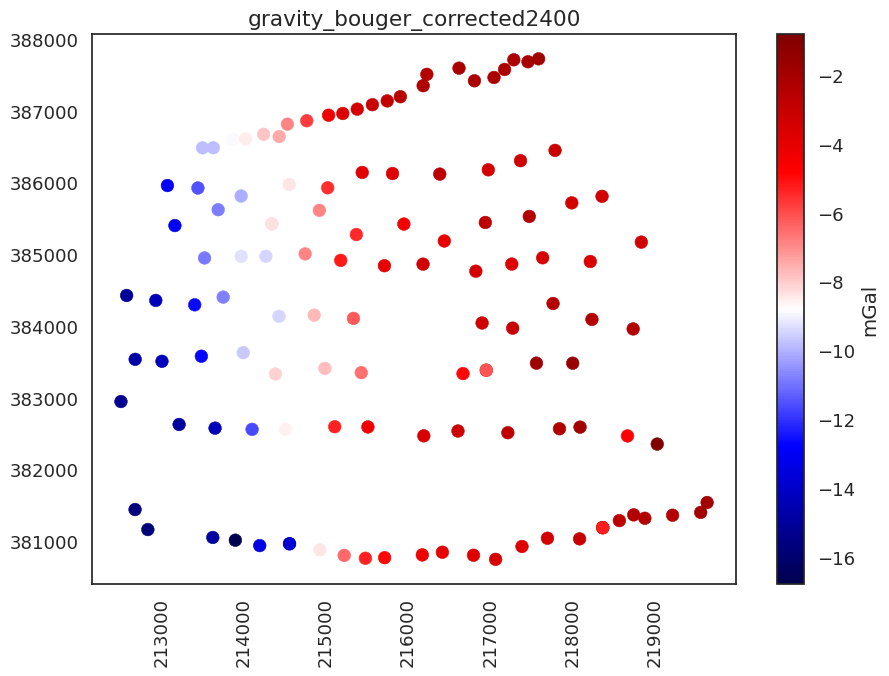

In [39]:
plt.scatter(df['X'], df['Y'], c=df['bouger anomaly'], cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="mGal")
plt.title('gravity_bouger_corrected2400')
plt.plot()
plt.show()

In [40]:
d_obs_x=np.array(d_obs_x)
d_obs_y=np.array(d_obs_y)
d_obs_z=np.array(d_obs_z)

In [41]:
#irregular data contour plotting - https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html
import matplotlib.tri as tri
# Interpolation on a grid
# -----------------------
# A contour plot of irregularly spaced data coordinates
# via interpolation on a grid.
ngridx=1000
ngridy=1000
xi = np.linspace(212000, 220000, ngridx)
yi = np.linspace(380000, 388000, ngridy)
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(d_obs_x, d_obs_y)
interpolator = tri.LinearTriInterpolator(triang, d_obs_z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

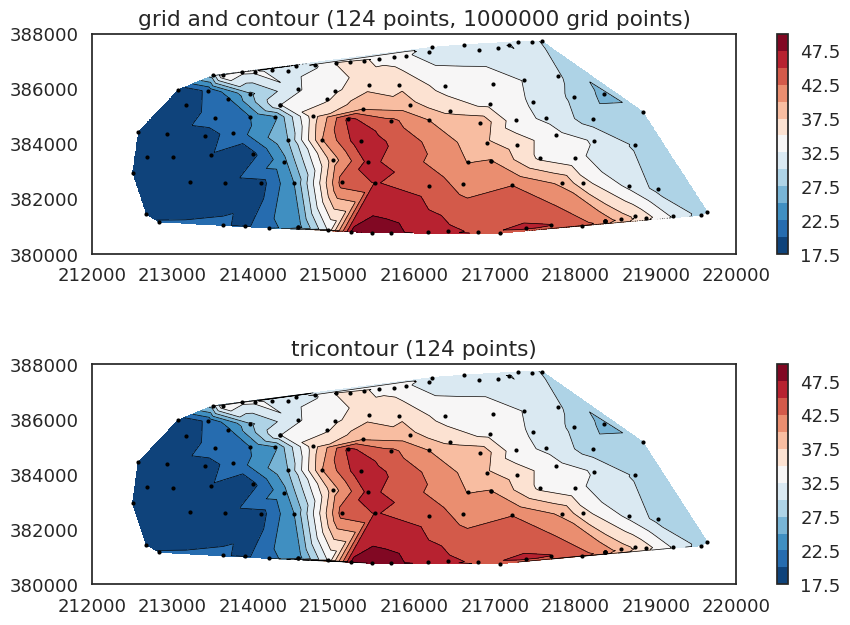

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
# Note that scipy.interpolate provides means to interpolate data on a grid
# as well. The following would be an alternative to the four lines above:
# from scipy.interpolate import griddata
# zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

ax1.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

fig.colorbar(cntr1, ax=ax1)
ax1.plot(d_obs_x, d_obs_y, 'ko', ms=3)
ax1.set(xlim=(212000, 220000), ylim=(380000, 388000))
ax1.set_title('grid and contour (%d points, %d grid points)' %
              (124, ngridx * ngridy))

# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

ax2.tricontour(d_obs_x, d_obs_y, d_obs_z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(d_obs_x, d_obs_y, d_obs_z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(d_obs_x, d_obs_y, 'ko', ms=3)
ax2.set(xlim=(212000, 220000), ylim=(380000, 388000))
ax2.set_title('tricontour (%d points)' % 124)

plt.subplots_adjust(hspace=0.5)
plt.show()


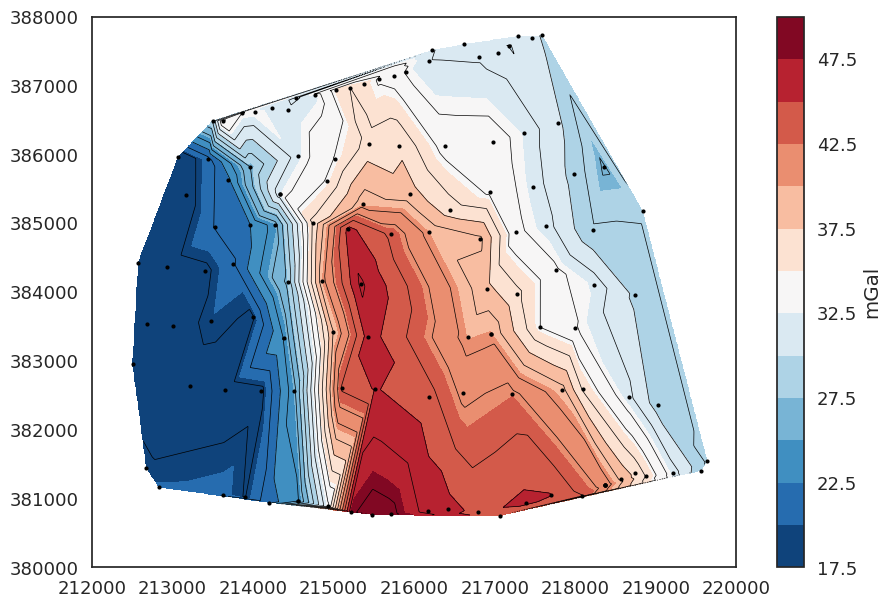

In [43]:
#realising that oasis montaj was unnecessary

plt.contour(xi, yi, zi, levels=20, linewidths=0.5, colors='k')
cntr1 = plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

fig.colorbar(cntr1, ax=ax1)
plt.plot(d_obs_x, d_obs_y, 'ko', ms=3)
plt.colorbar(label="mGal")

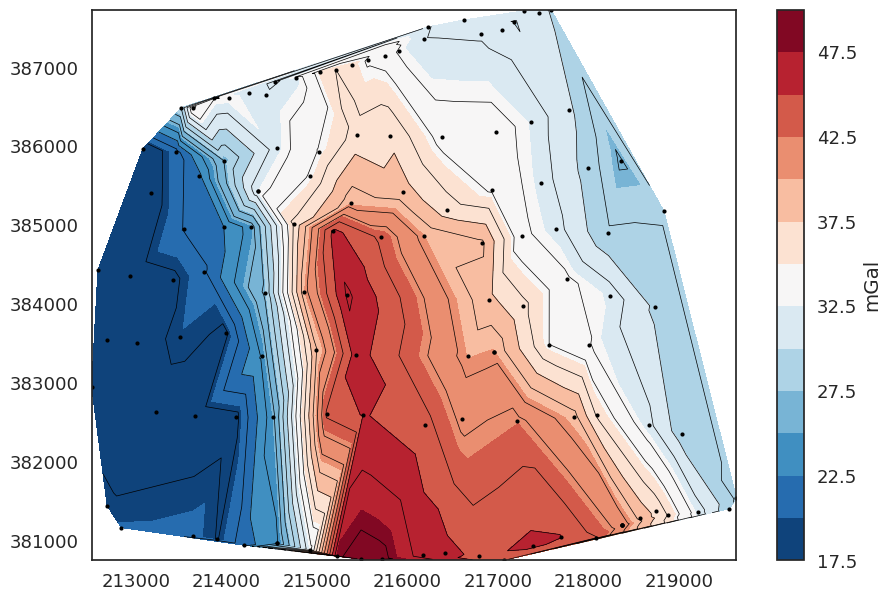

In [44]:
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

plt.tricontour(d_obs_x, d_obs_y, d_obs_z, levels=20, linewidths=0.5, colors='k')
cntr2 = plt.tricontourf(d_obs_x, d_obs_y, d_obs_z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
plt.plot(d_obs_x, d_obs_y, 'ko', ms=3)
plt.colorbar(label="mGal")

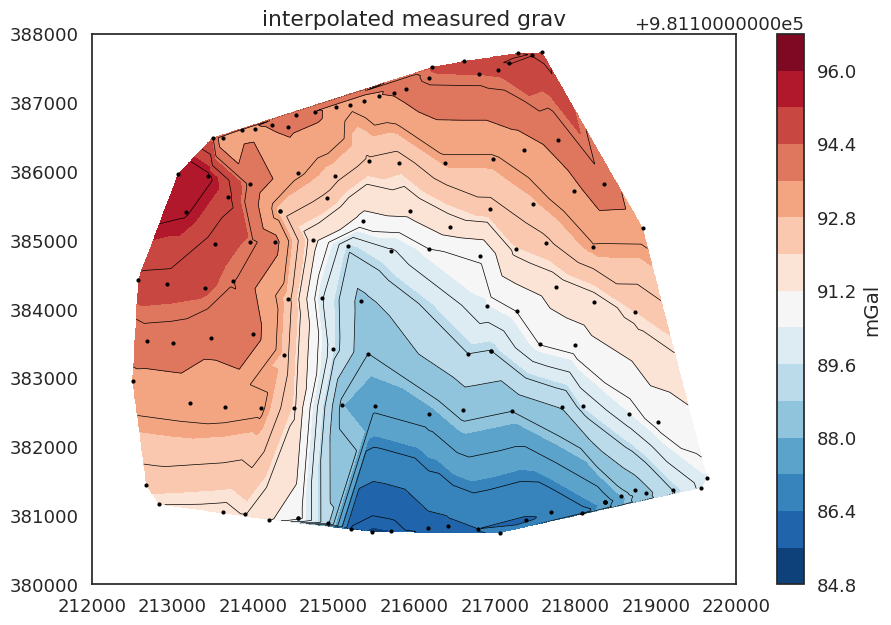

In [45]:
#more interpolations 
triang = tri.Triangulation(d_obs_x, d_obs_y)

#here you put the desired value, eg. elevation, gravit
interpolator = tri.LinearTriInterpolator(triang, d_obs_grav)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
plt.contour(xi, yi, zi, levels=20, linewidths=0.5, colors='k')
cntr1 = plt.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")
plt.title('interpolated measured grav')
fig.colorbar(cntr1, ax=ax1)
plt.plot(d_obs_x, d_obs_y, 'ko', ms=3)
plt.colorbar(label="mGal")

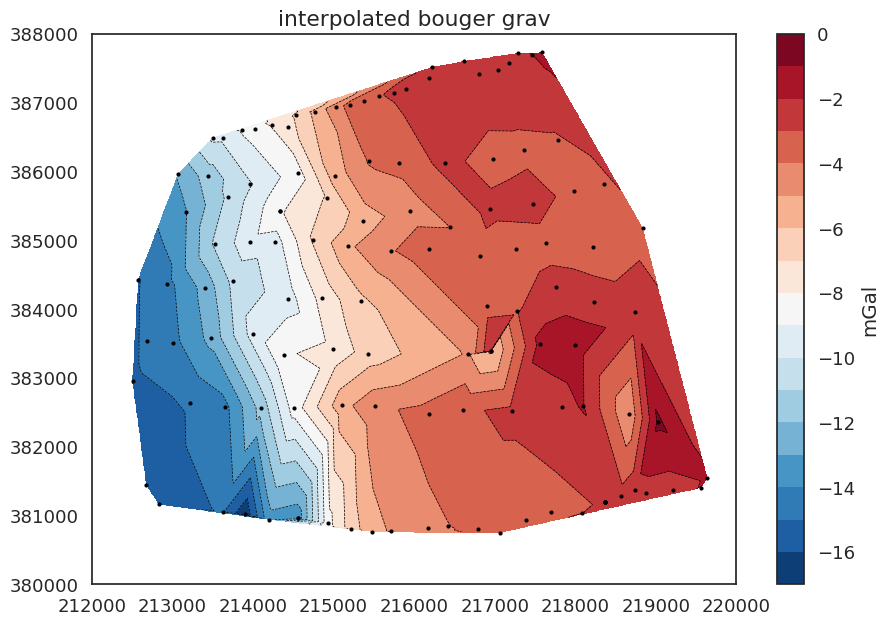

In [46]:
#more interpolations 
triang = tri.Triangulation(d_obs_x, d_obs_y)

#here you put the desired value, eg. elevation, gravit
interpolator = tri.LinearTriInterpolator(triang, df['bouger anomaly'])
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
plt.contour(xi, yi, zi, levels=18, linewidths=0.5, colors='k')
cntr1 = plt.contourf(xi, yi, zi, levels=18, cmap="RdBu_r")
plt.title('interpolated bouger grav')
fig.colorbar(cntr1, ax=ax1)
plt.plot(d_obs_x, d_obs_y, 'ko', ms=3)
plt.colorbar(label="mGal")

In [47]:
points2 = np.column_stack((d_obs_x, d_obs_y, d_obs_z))


In [69]:
points2

array([[2.18366512e+05, 3.81192513e+05, 4.14175000e+01],
       [2.18569615e+05, 3.81290638e+05, 3.86000000e+01],
       [2.18743299e+05, 3.81370586e+05, 3.70550000e+01],
       [2.18878797e+05, 3.81323116e+05, 3.59175000e+01],
       [2.19216512e+05, 3.81365432e+05, 3.21200000e+01],
       [2.19558156e+05, 3.81404706e+05, 2.88525000e+01],
       [2.19636402e+05, 3.81542673e+05, 2.82375000e+01],
       [2.18085862e+05, 3.81036032e+05, 4.36075020e+01],
       [2.17694752e+05, 3.81044647e+05, 4.50600000e+01],
       [2.17385165e+05, 3.80930009e+05, 4.53650000e+01],
       [2.17064326e+05, 3.80750503e+05, 4.38125000e+01],
       [2.16795342e+05, 3.80807407e+05, 4.45950000e+01],
       [2.16172993e+05, 3.80812321e+05, 4.59000000e+01],
       [2.16417033e+05, 3.80849655e+05, 4.54950030e+01],
       [2.15714817e+05, 3.80773437e+05, 4.84150000e+01],
       [2.15481129e+05, 3.80765748e+05, 4.87325000e+01],
       [2.15223573e+05, 3.80805405e+05, 4.77750000e+01],
       [2.14927636e+05, 3.80884

In [48]:
#another try at forward operator
#with mid size model 6 minutes for the bar, and following more runtime ~20min more
fop2 = GravityModelling(points2)

12/07/23 - 10:23:29 - Core - INFO - copy mesh for forward tasks.


   0%|          |0/124 [00:00 < ?]

In [76]:
np.max(points2[:,0])

219636.4017

In [75]:
grid.xMax()

218000.0

In [49]:
data2 = fop2.response(grid["synth"])

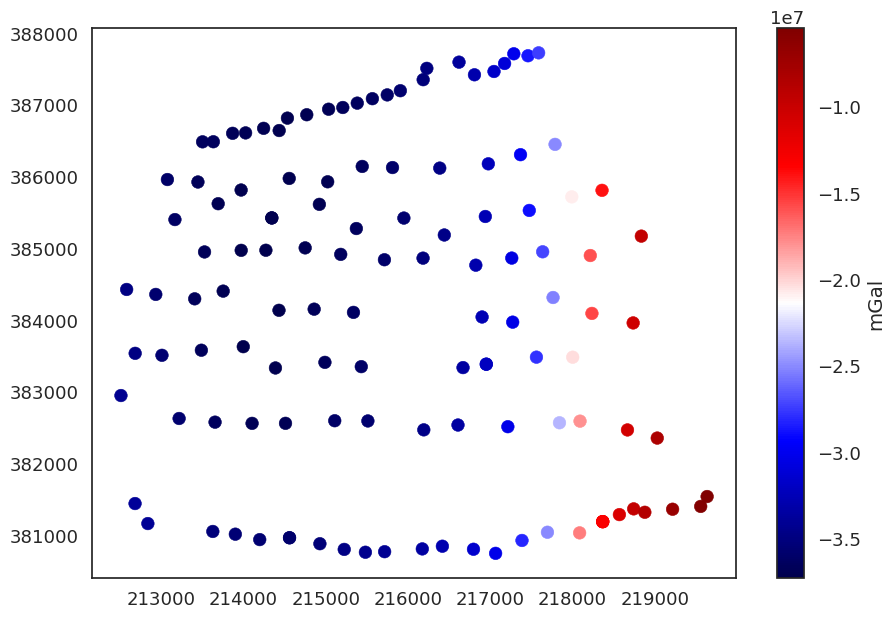

In [50]:
data2
plt.scatter(d_obs_x, d_obs_y, c=data2, cmap='seismic')
plt.colorbar(label="mGal")

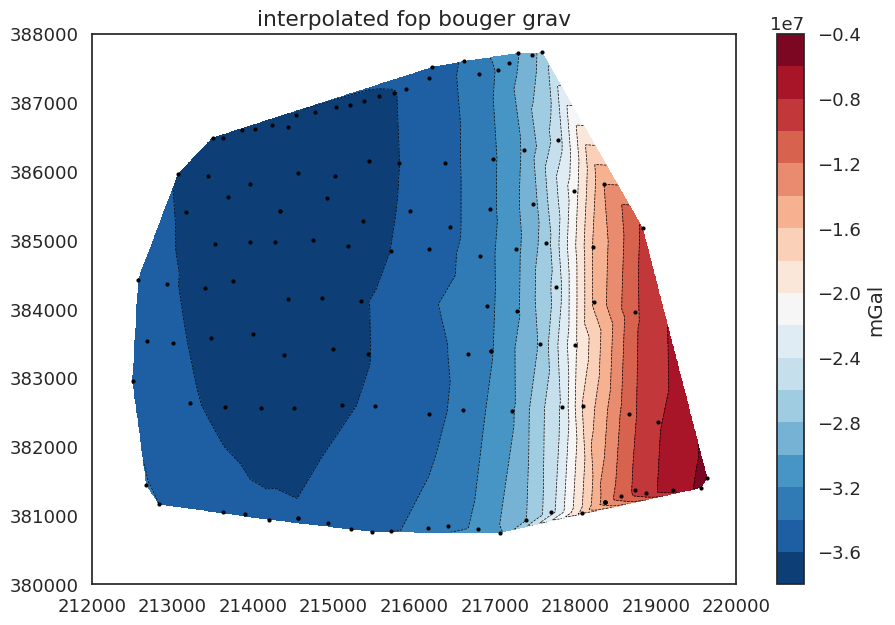

In [51]:
interpolator = tri.LinearTriInterpolator(triang, data2)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
plt.contour(xi, yi, zi, levels=18, linewidths=0.5, colors='k')
cntr1 = plt.contourf(xi, yi, zi, levels=18, cmap="RdBu_r")
plt.title('interpolated fop bouger grav')
fig.colorbar(cntr1, ax=ax1)
plt.plot(d_obs_x, d_obs_y, 'ko', ms=3)
plt.colorbar(label="mGal")

In [ ]:
#forward operator 
d_obs_xd_obs_x, d_obs_yd_obs_y = np.meshgrid(d_obs_x, d_obs_y)
points = np.column_stack((d_obs_xd_obs_x.ravel(), d_obs_yd_obs_y.ravel(), -np.ones(np.prod(d_obs_xd_obs_x.shape))))
fop = GravityModelling(grid, points)
data = fop.response(grid["synth"])
noise_level = 0.1
data += np.random.randn(len(data)) * noise_level
plt.contourf(d_obs_xd_obs_x, d_obs_yd_obs_y, np.reshape(data, d_obs_xd_obs_x.shape), cmap='seismic')
plt.colorbar();

In [ ]:
points

In [ ]:
grid

## Depth weighting

In the paper of Li & Oldenburg (1996), they propose a depth weighting of the constraints with the formula

\begin{align}w_z = \frac{1}{(z+z_0)^{3/2}}\end{align}


In [52]:
# depth weighting
bz = np.array([b.center().z() for b in grid.boundaries() if not b.outside()])
z0 = 1
wz = 1/ (bz+z0)**1.5
fop2.region(0).setConstraintWeights(wz)

In [53]:
#error estimation
#what about d_pre? taking the forward model
#for now default 
err = 0.01
noise_level = 1e-9
relError = noise_level / np.abs(d_obs_grav) + err
d_obs_grav *= np.random.randn(*d_obs_grav.shape)*relError + 1.0

(array([  0.,   0.,   0.,   0.,   0., 124.,   0.,   0.,   0.,   0.]),
 array([-0.49, -0.39, -0.29, -0.19, -0.09,  0.01,  0.11,  0.21,  0.31,
         0.41,  0.51]),
 <BarContainer object of 10 artists>)

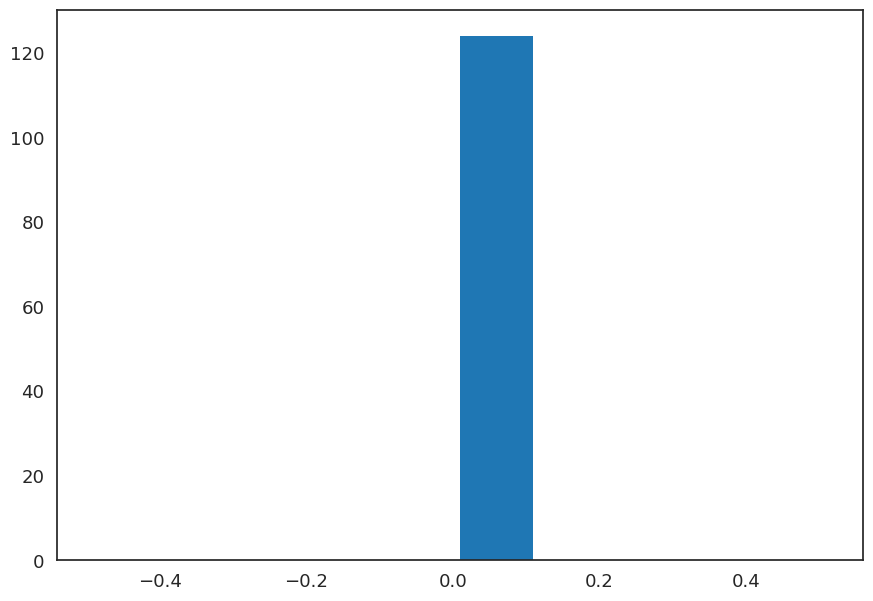

In [59]:
#dev version
inv = pg.Inversion(fop=fop2, verbose=True)  # , debug=True)
#inv.modelTrans = pg.trans.TransCotLU(-2, 2)
#inv.setRegularization(correlationLengths=[500, 500, 100])
inv.setConstraintWeights(wz)
invmodel = inv.run(data2, absoluteError=noise_level, lam=3e4,  verbose=True)
#zWeight=0.3
grid["inv"] = invmodel

12/07/23 - 10:59:40 - pyGIMLi - INFO - Starting inversion.


min/max(cWeight) = 8.30455e-06/0.00197624
min/max(dweight) = 2.68093e-06/1.84793e-05
fop: <__main__.GravityModelling object at 0x14f9ffa852c0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x14f9ff0b2a00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x14f9ff7e6f40>
min/max (data): -3.7e+07/-5.4e+06
min/max (error): 1%/1%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
min/max(dweight) = 2.68093e-06/1.84793e-05
Building constraints matrix
--------------------------------------------------------------------------------
inv.iter 1 ... constraint matrix of size(nBounds x nModel) 22800 x 8000
calculating jacobian matrix (forced=1)...... 2.2033e-05 s
min data = -3.73004e+07 max data = -5.41146e+06 (124)
min error = 0.01 max error = 0.01 (124)
min response = -1208.25 max response = -183.093 (124)
calc without reference model
0: rms/rrms(data, response) = 3.19116e+07/99.9968%
0: chi^2(data, response, error

12/07/23 - 11:00:07 - Core - ERROR - Model contains nan values.
12/07/23 - 11:00:07 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.36 (dPhi = 0.0%) lam: 30000.0
--------------------------------------------------------------------------------
inv.iter 2 ... calculating jacobian matrix (forced=1)...... 3.365e-05 s
solve CGLSCDWWtrans with lambda = 30000


12/07/23 - 11:00:37 - Core - ERROR - Model contains nan values.
12/07/23 - 11:00:37 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.36 (dPhi = 0.0%) lam: 30000.0
--------------------------------------------------------------------------------
inv.iter 3 ... calculating jacobian matrix (forced=1)...... 3.7466e-05 s
solve CGLSCDWWtrans with lambda = 30000


12/07/23 - 11:01:09 - Core - ERROR - Model contains nan values.
12/07/23 - 11:01:09 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.36 (dPhi = 0.0%) lam: 30000.0
--------------------------------------------------------------------------------
inv.iter 4 ... calculating jacobian matrix (forced=1)...... 3.8819e-05 s
solve CGLSCDWWtrans with lambda = 30000


12/07/23 - 11:01:38 - Core - ERROR - Model contains nan values.
12/07/23 - 11:01:38 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(inversion.py:676)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 9999.36 (dPhi = 0.0%) lam: 30000.0
################################################################################
#                 Abort criteria reached: dPhi = 0.0 (< 2.0%)                  #
################################################################################


In [60]:
invmodel

8000 [0.1,...,0.1]

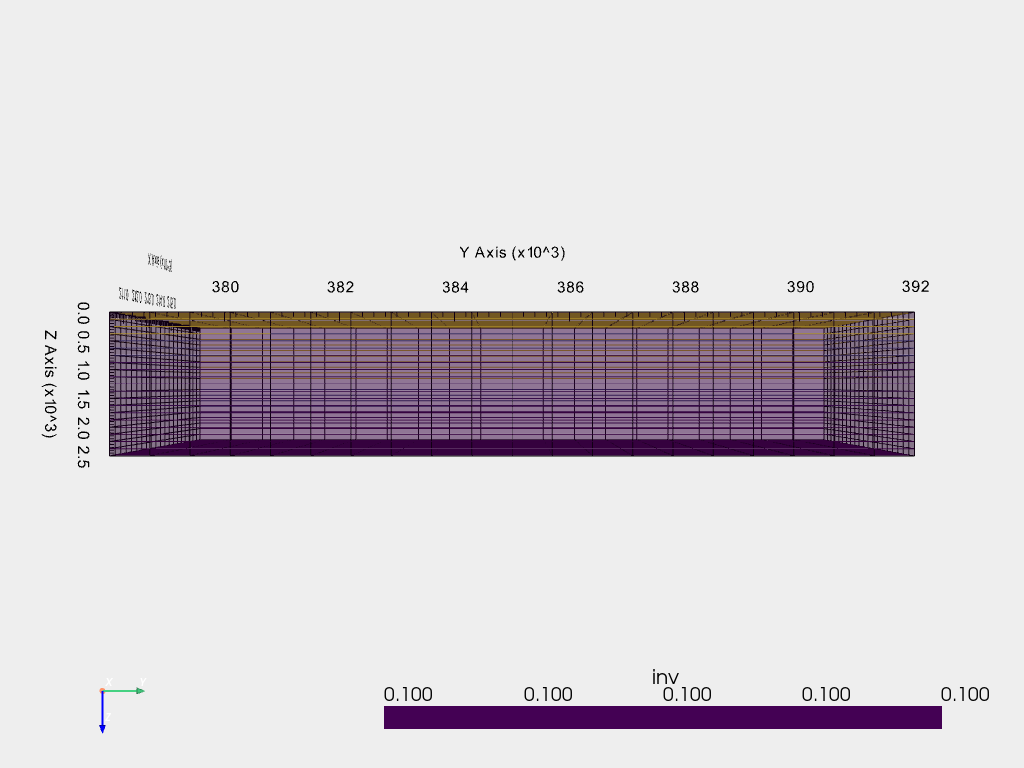

In [63]:
ftr = dict(value=0.5, scalars="synth")
pl, _ = pg.show(grid, label="synth", style="wireframe",
                #originally on# filter={"threshold": ftr},
                hold=True, backend="trame")
ftr = dict(value=0.3, scalars="inv")
pv.drawMesh(pl, grid, label="inv", style="surface", alpha=0.3
#originally on# filter={"threshold": ftr},
        )
pl.camera_position = "yz"

pl.camera.roll = 90
pl.camera.azimuth = 180
pl.camera.zoom(1.1)
_ = pl.show()

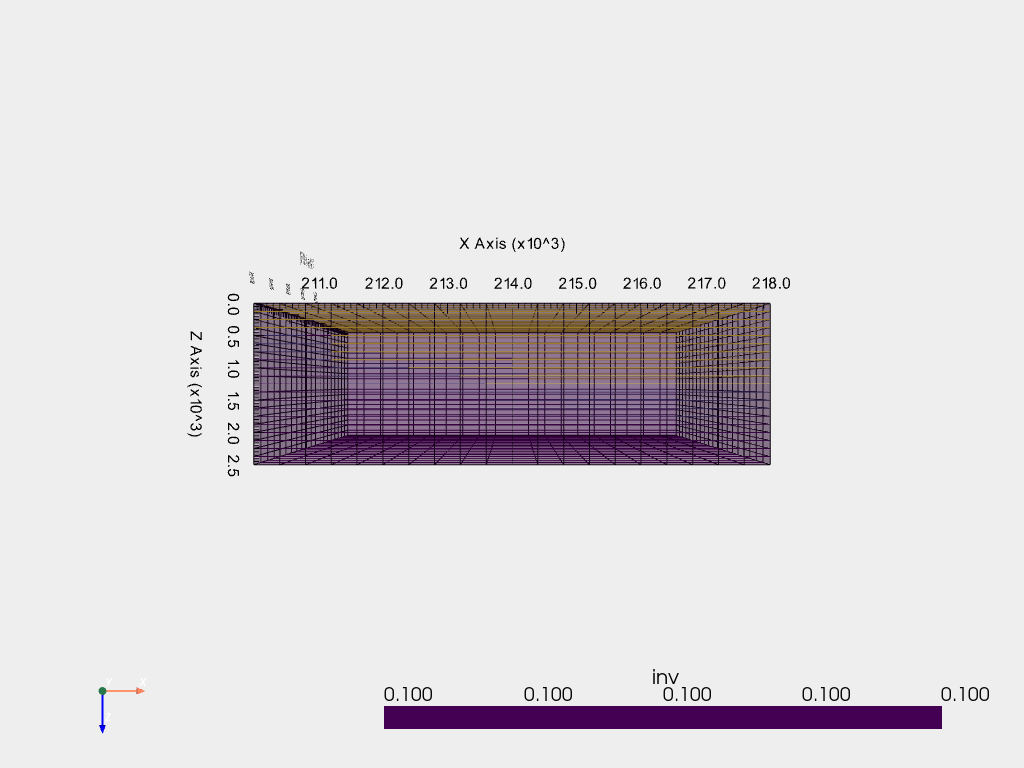

In [64]:
ftr = dict(value=0.5, scalars="synth")
pl, _ = pg.show(grid, label="synth", style="wireframe",
                #originally on# filter={"threshold": ftr},
                hold=True, backend="trame")
ftr = dict(value=0.3, scalars="inv")
pv.drawMesh(pl, grid, label="inv", style="surface", alpha=0.3
#originally on# filter={"threshold": ftr},
        )
pl.camera_position = "yz"

pl.camera.roll = 90
pl.camera.azimuth = 270
pl.camera.zoom(1.1)
_ = pl.show()

In [72]:
slice = pg.meshtools.extract2dSlice(grid)
_, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
pg.show(slice, "synth", ax=ax[0])
pg.show(slice, "inv", ax=ax[1])
ax[0].set_ylim(ax[0].get_ylim()[::-1])

KeyError: 'Data array (block_matrix) not present in this dataset.'

In [ ]:
##not original github -> some gempy forward modelling

In [ ]:
#Runs for ever, kernel dies
#gp.plot_3d(geo_model)

In [ ]:
grav_resx = 30
grav_resy = 10
X = np.linspace(200,1800, grav_resx)
Y = np.linspace(200,1800, grav_resy)
Z = 700
xyz = np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T
xy_ravel

In [ ]:
gp.plot_2d(geo_model, direction='z', show=False, cell_number=20)
plt.scatter(xy_ravel[:, 0], xy_ravel[:, 1], s=20)
plt.show()

In [ ]:
geo_model.add_surface_values([0,1.900,2.500,2.600,2.700,3.000])

In [ ]:
geo_model.set_centered_grid(xy_ravel, resolution=[10, 10, 15], radius=300)

In [ ]:
geo_model.grid.centered_grid?

In [ ]:
from gempy.assets.geophysics import GravityPreprocessing
g = GravityPreprocessing(geo_model.grid.centered_grid)

In [ ]:
g

In [ ]:
tz = g.set_tz_kernel()
tz

In [ ]:
geo_model.surfaces

In [ ]:
gp.set_interpolator(geo_model, output=['gravity'], gradient=True,
                    theano_optimizer='fast_run')

In [ ]:
sol = gp.compute_model(geo_model)
grav = sol.fw_gravity

In [ ]:
grav

In [ ]:
grav1 = grav.reshape(len(grav),1)
station_forw_grav = np.round(np.append(xy_ravel, grav1, axis=1),4)
# make everything into a dataframe
df_stations = pd.DataFrame(station_forw_grav, columns=["X", "Y", "Z", "grav"])
# round X Y and Z to 2 decimals
df_stations[['X','Y','Z']] = np.around(df_stations[['X','Y','Z']], 2)

In [ ]:
df_stations

In [ ]:
gp.plot_2d(geo_model, direction=['z'], height=7, show_results=True, show_data=False , legend=True, kwargs_regular_grid={'alpha': .5})

plt.scatter(xy_ravel[:, 0], xy_ravel[:, 1], s=20)
im = plt.imshow(sol.fw_gravity.reshape(grav_resy, grav_resx),
           extent=(50,
                   xy_ravel[:, 0].max() - (xy_ravel[0, 0] - xy_ravel[1, 0]) / 2,
                   xy_ravel[:, 1].min() + (xy_ravel[0, 1] - xy_ravel[30, 1]) / 2,
                   xy_ravel[:, 1].max() - (xy_ravel[0, 1] - xy_ravel[30, 1]) / 2),
           cmap='viridis_r', origin='lower')
plt.colorbar(im, label='uGal')
plt.savefig(f'gravityresponse_{grav_resy}x{grav_resx}.png')
plt.show()


In [ ]:
gp.plot_2d(geo_model, direction='y', show=False, cell_number=10)
#plt.scatter(xy_ravel[:, 0], xy_ravel[:, 1], s=20)
plt.show()

In [ ]:
gp.plot_3d(geo_model)

In [ ]:
df_stations.to_csv('../../data/Data_for_MC/20210322_forw_grav_seed58.csv', index=False)


In [ ]:
(pgmesh_new.xmax() - pgmesh_new.xmin()) / 50

In [ ]:
#Getting 3D geometry 
pgmesh_new = mt.fromSubsurface(gempymesh, order='F')

res = np.zeros(pvec.shape[0])
(unique, counts) = np.unique(pvec, return_counts=True)
layers = np.asarray(unique)
print(layers)

## Assign values to new dens vec 
res[pvec==6] = 1000
res[pvec==5] = 10
res[pvec==4] = 500
res[pvec==3] = 600
res[pvec==2] = 600

nelecs = 42
elec_x = np.linspace(200, 1800, nelecs)
elec_y = np.ones(len(elec_x)) * ((pgmesh_new.ymax() - pgmesh_new.ymin())/2)
elec_z = np.ones(len(elec_x)) * 749
sensors = np.stack((elec_x, elec_y, elec_z)).T

#%% 
scheme = ert.createData(elecs=sensors, schemeName='dd')
k = ert.geometricFactors(scheme)

for i in sensors:
      idnode = pgmesh_new.findNearestNode(pos=i)
#     pgmesh_new.node(idnode).setPos(pos=[i[0],i[1],i[2]])
      pos = pgmesh_new.node(idnode).pos()
      print(pos)
      print(i)
      if pos == i:
         print('Same location')
      else:
         print('different Location')


#%% 
pg.show(pgmesh_new, res, label='Ohm m', hold=True)
sargs = dict(
    title_font_size=25,
    label_font_size=60,
    shadow=True,
    n_labels=3,
    italic=True,
    fmt="%.1f",
    font_family="arial",
)
#drawSensors(plotter, sensors, diam=5, color='red', scalar_bar_args=sargs)

pg.show(pgmesh_new, label=res)


In [ ]:
plotter, _ = pg.show(pgmesh_new, res, label='Ohm m')
sargs = dict(
    title_font_size=25,
    label_font_size=60,
    shadow=True,
    n_labels=3,
    italic=True,
    fmt="%.1f",
    font_family="arial",
    notebook=True
)
drawSensors(plotter, sensors, diam=5, color='red', scalar_bar_args=sargs)

In [ ]:
k_l, k_r, k_c = geo_model.grid.centered_grid.kernel_dxyz_left, geo_model.grid.centered_grid.kernel_dxyz_right, geo_model.grid.centered_grid.kernel_centers


In [ ]:
#Top marker is natural Neumann 
#Xmin- Xmax , Ymin and Ymax = -2
#%% 
pg.tic()
syndata = ert.simulate(pgmesh_new, scheme=scheme, res=res, noiseLevel=0.02, noiseAbs=1e-8)
pg.toc()
#syndata.remove(syndata['rhoa'] < 0)


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,7)) 
ax2, cbar = pg.show(syndata, ax=ax, hold=True, logScale=False)
#cbar.ax.set_xticks([100,400,700,1000,1300,1600])  # horizontal colorbar
#cbar.ax.set_xticklabels([100,400,700,1000,1300,1600])

In [ ]:
grid['inv']

In [ ]:
pg.meshtools.readMeshIO(grid)